# Part I : Quel(le) data scientist êtes-vous ?
## Contexte de l’analyse

Elu métier le plus sexy par la Harvard Business Review en octobre 2012, le data scientist représente un profil rare qui exige de nombreuses compétences.

A partir d'un dataset Aquila, vous réaliserez :
- un clustering non supervisé afin d'identifier 2 groupes de profils techniques distinctes
- une prédiction des profils dont le métier n'est pas labellisé


## Données
data.csv contient 6 variables : 
    - 'Entreprise' correspond à une liste d'entreprises fictive
    - 'Metier' correspond au métier parmi data scientist, lead data scientist, data engineer et data architecte
    - 'Technologies' correspond aux compétences maîtrisées par le profil
    - 'Diplome' correspond à son niveau scolaire (Bac, Master, PhD,...)
    - 'Experience' correspond au nombre d'années d'expériences
    - 'Ville' correspond au lieu de travail
    


## Répondez aux questions 

Bonne chance!

In [64]:
# Import des libraries classique (numpy, pandas, ...)
import pandas as pd
import numpy as np
import re
import sklearn as sk
import seaborn as sb
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
import functools

### 1) Importer le tableau de données dans un dataframe 

In [4]:
# Detecter le separateur
ligne_a_lire = 6
with open('data.csv','r') as file:
    for i in range(ligne_a_lire):
        print(file.readline())

Entreprise,Metier,Technologies,Diplome,Experience,Ville

Sanofi,Data scientist,Matlab/Python/Pyspark/Scikit-learn/Tensorflow,Master,1,Paris

Massachusetts General Hospital(MGH),Data architecte,Python/Java/Scala/MongoDB,Master,3,Marseille

Delve,Lead data scientist,SPSS/SQL/Teradata/R/Python/Tensorflow/scikit-learn,Master,3,Nantes

Ann & Robert H. Lurie Childrenâ€™s Hospital of Chicago,Data scientist,C/C++/Java/Python,Master,"1,5",Marseille

Arm,Data scientist,Matlab/Python/C++/numpy/Tensorflow/scikit-learn,Phd,,Bordeaux



Le separateur de columnes ici est une <b>','</b>. Nous allons l'utiliser avec pandas 

In [5]:
# Import du dataframe "data.csv"
filename = 'data.csv'
df = pd.read_csv(filename, sep=',', decimal=',')

In [6]:
# Avoir un apercu des premieres lignes du fichier
nombre_lignes_a_visualiser = 5
df.head(nombre_lignes_a_visualiser)

,Entreprise,Metier,Technologies,Diplome,Experience,Ville
0,Sanofi,Data scientist,Matlab/Python/Pyspark/Scikit-learn/Tensorflow,Master,1.0,Paris
1,Massachusetts General Hospital(MGH),Data architecte,Python/Java/Scala/MongoDB,Master,3.0,Marseille
2,Delve,Lead data scientist,SPSS/SQL/Teradata/R/Python/Tensorflow/scikit-l...,Master,3.0,Nantes
3,Ann & Robert H. Lurie Children’s Hospital of C...,Data scientist,C/C++/Java/Python,Master,1.5,Marseille
4,Arm,Data scientist,Matlab/Python/C++/numpy/Tensorflow/scikit-learn,Phd,NaN,Bordeaux


In [7]:
# Avoir un apercu du fichier csv "data.csv"
df.head()

,Entreprise,Metier,Technologies,Diplome,Experience,Ville
0,Sanofi,Data scientist,Matlab/Python/Pyspark/Scikit-learn/Tensorflow,Master,1.0,Paris
1,Massachusetts General Hospital(MGH),Data architecte,Python/Java/Scala/MongoDB,Master,3.0,Marseille
2,Delve,Lead data scientist,SPSS/SQL/Teradata/R/Python/Tensorflow/scikit-l...,Master,3.0,Nantes
3,Ann & Robert H. Lurie Children’s Hospital of C...,Data scientist,C/C++/Java/Python,Master,1.5,Marseille
4,Arm,Data scientist,Matlab/Python/C++/numpy/Tensorflow/scikit-learn,Phd,NaN,Bordeaux


### 2) Combien y a t-il d'observations dans ce dataset? Y a t-il des valeurs manquantes? 

In [8]:
# methode 1 : avec shape
# methode 2 : avec len
print(' methode 1: nombre d\'attributs du dataset {} \n'.format(df.shape[0]))
print(' methode 2: nombre d\'attributs du dataset {} \n'.format(len(df)))


 methode 1: nombre d'attributs du dataset 9582 

 methode 2: nombre d'attributs du dataset 9582 



In [9]:
# Avoir une idee du type des differentes columnes du dataset
df.dtypes

Entreprise       object
Metier           object
Technologies     object
Diplome          object
Experience      float64
Ville            object
dtype: object

In [10]:
## Apercu des valeurs manquantes
## Calculons la proportion de valeurs manquantes dans chacune des columnes
print('proportion des valeurs manquantes dans chacune des columnes en % \n')
print(df.isnull().mean()*100)

proportion des valeurs manquantes dans chacune des columnes en % 

Entreprise      0.177416
Metier          0.198288
Technologies    0.000000
Diplome         0.000000
Experience      0.981006
Ville           0.000000
dtype: float64


La variable <b> Experience </b> correspondant au nombre d'années d'expereiences, il etait à mon sens necessaire de la convertir en <b> float </b>
<br> Concernant les valeurs manquantes, je constate que les variables categorielles <b> Entreprise</b>, <b>Metier</b> en contiennent approximativement et respectivement <b>0.17%</b> et <b>0.18%</b> tandis que la variable numerique <b>Experience</b> en contient moins de <b>1%</b>.
<br> Ces donnees manquantes sont assez rares (moins de 1%) en general, le dataset est donc exploitable et on peut remplacer ces valeurs manquantes par diverses méthodes (moyenne, medianne, mode (pour les variables categorielles)

### 3) Réaliser l'imputation des valeurs manquantes pour la variable "Experience" avec : 
- la valeur médiane pour les data scientists
- la valeur moyenne pour les data engineers

Plusieurs méthodes peuvent être utilisées pour mener à bien cette operation, soit diviser le dataset en 2. Un dataset specifique aux datascientist et un autre aux data engineer et faire cette operation et ensuite concatener pour avoir le dataset de depart.
Autre méthode ne pas diviser le dataset et operer directement

In [18]:
# Realisation de l'imputation de la valeur manquante
## Remplacer les valeurs manquantes pour les data scientists par la valeur mediane
index_data_scientist = list(df[df.Metier.isin(['Data scientist'])].isnull().index.values)
df.loc[index_data_scientist,'Experience'] = df.loc[index_data_scientist,'Experience'].transform(lambda col:col.fillna(col.median()))

## Remplacer les valeurs manquantes pour les data engineers par la moyenne
index_data_engineer = list(df[df.Metier.isin(['Data engineer'])].isnull().index.values)
df.loc[index_data_engineer,'Experience'] = df.loc[index_data_engineer,'Experience'].transform(lambda col:col.fillna(col.mean()))


Il existe surement des méthodes plus optimisées mais celle la me parait pas, j'aurai le temps de reflechir à d'autres méthodes et calculer la plus rapide

### 4) Combien d'années d'expériences ont, en moyenne, chacun des profils : le data scientist, le lead data scientist et le data engineer en moyenne?

In [28]:
### Calcul des annees d'eperience en moyenne
print('moyenne experience lead data scientist {} \n'.format(df[df.Metier=='Lead data scientist']['Experience'].mean()))
print('moyenne experience data scientist {} \n'.format(df[df.Metier=='Data scientist']['Experience'].mean()))
print('moyenne experience data engineer {} \n'.format(df[df.Metier=='Data engineer']['Experience'].mean()))

moyenne experience lead data scientist 3.965260545905707 

moyenne experience data scientist 2.2432820245238716 

moyenne experience data engineer 2.984959174903309 



In [29]:
df.Metier.value_counts()

Data scientist         3865
Data engineer          2347
Data architecte        2123
Lead data scientist    1228
Name: Metier, dtype: int64

### 5) Faire la représentation graphique de votre choix afin de comparer le nombre moyen d'années d'expériences pour chaque métier

Text(0.5,1,"Annee d'experience de divers acteurs de la data")

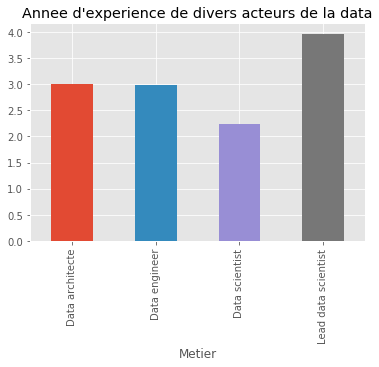

In [30]:
df.groupby('Metier')['Experience'].mean().plot(kind='bar')
plt.title('Annee d\'experience de divers acteurs de la data')

In [55]:
df.groupby('Metier')['Experience'].std()

Metier
Data architecte        2.723786
Data engineer          2.766717
Data scientist         2.516554
Lead data scientist    2.693818
Name: Experience, dtype: float64

In [33]:
df.groupby('Metier')['Experience'].min()

Metier
Data architecte        0.0
Data engineer          0.0
Data scientist         0.0
Lead data scientist    0.0
Name: Experience, dtype: float64

In [34]:
df.groupby('Metier')['Experience'].max()

Metier
Data architecte        15.0
Data engineer          15.0
Data scientist         21.0
Lead data scientist    21.0
Name: Experience, dtype: float64

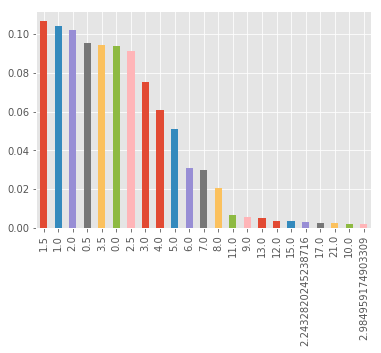

In [38]:
(df['Experience'].sort_values(ascending=True).value_counts()/df.shape[0]).plot(kind='bar')

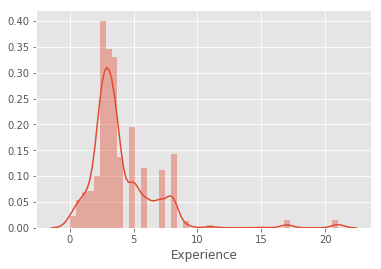

In [62]:
import seaborn as sns
df2 = df.copy()
df2 = df2.dropna(subset=['Experience'], how='all')
val = df2[df2.Metier=='Lead data scientist']['Experience']

sns.distplot(val)


Une question se pose ici, le nombre d'annee d'experience par exemple d'un data scientist est t'il le nombre d'annee pendant lequel il a effectué cette fonction ou son nombre d'année d'experience totale. Le data scientist etant par nature amener à evoluer pour devenir lead <br> data scientist </br>.
On va partir de l'hypothèse qu'il s'agit du nombre totale d'année en activité y compris celui en tant que data scientist
Il faudra calculer la dispersion autour de la moyenne pour voir si le nombre d'annee d'experience pour passer au stade de lead data scientist est variable ou non.
Le nombre d'annee d'experience d'un lead data scientist est plus elevée que ceux des simples ingénieurs, ce qui nous conforte dans cette hypothèse. I

### 6) Transformer la variable continue 'Experience' en une nouvelle variable catégorielle 'Exp_label' à 4 modalités: débutant, confirmé, avancé et expert
- Veuillez expliquer votre choix du règle de transformation.  

On va partir du postulat qu'un lead data scientist est un <b> avance </b> <br> En effet ce dernier est amené à gerer une equipe de data scientist debutants( sortant d'ecoles et de confirmés), la valeur mediane du lead data scientist etant de 3.5 et la moyenne de 3.96, on va considere qu'a partir de 4 ans d'experience, un ingénieur (architecte, data scientist etc...) deviens expert dans son domaine

In [57]:
def categorized_variable(value):
    if value<2:
        return 'Debutant'
    elif value>=2 and value<4:
        return 'Confirme'
    elif value>=4 and value<=8:
        return 'Avance'
    else:
        return 'Expert'
df['Exp_label'] = df['Experience'].apply(categorized_variable)

In [58]:
df.head(5)

,Entreprise,Metier,Technologies,Diplome,Experience,Ville,Exp_label
0,Sanofi,Data scientist,Matlab/Python/Pyspark/Scikit-learn/Tensorflow,Master,1.000000,Paris,Debutant
1,Massachusetts General Hospital(MGH),Data architecte,Python/Java/Scala/MongoDB,Master,3.000000,Marseille,Confirme
2,Delve,Lead data scientist,SPSS/SQL/Teradata/R/Python/Tensorflow/scikit-l...,Master,3.000000,Nantes,Confirme
3,Ann & Robert H. Lurie Children’s Hospital of C...,Data scientist,C/C++/Java/Python,Master,1.500000,Marseille,Debutant
4,Arm,Data scientist,Matlab/Python/C++/numpy/Tensorflow/scikit-learn,Phd,2.243282,Bordeaux,Confirme


### 7) Quelles sont les 5 technologies les plus utilisées? Faites un graphique

Listons l'ensemble des technologies utilisées par l'ensemble des candidats

In [74]:
[0,1,2]+[3,4,5]

[0, 1, 2, 3, 4, 5]

In [85]:
logiciels_utilises = list(map(lambda x:x.split('/'), df.Technologies))

liste_des_logiciels_utilises = [val for sublist in logiciels_utilises for val in sublist]
liste_unique_des_logiciels_utilises = list(set([val for sublist in logiciels_utilises for val in sublist]))

 tableau [1589, 1719, 2581, 4374, 6627]


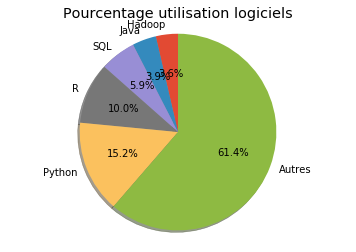

In [116]:
liste_n_largest = 5
sizes = [liste_des_logiciels_utilises.count(elt) for elt in liste_unique_des_logiciels_utilises]
index = np.argsort(sizes)[-liste_n_largest:]
labels = np.asarray(liste_unique_des_logiciels_utilises, dtype=str)
labels = list(labels[index])
labels.append ('Autres') #rajouter les autres qu'on a pas comptabiliser
sizes2 =np.asarray(sizes)[index]
sizes2 = list(sizes2)
print(' tableau', sizes2)
sizes2.append(len(liste_des_logiciels_utilises)-sum(sizes2)) 
fig1, ax1 = plt.subplots()
ax1.pie(sizes2, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')
plt.title('Pourcentage utilisation logiciels')
plt.show()

### 8) Réaliser une méthode de clustering non supervisée de votre choix pour faire apparaître 2 clusters que vous jugerez pertinents. Donnez les caractéristiques de chacun des clusters.
-  Justifier la performance de votre algorithme grace à une métrique.
-  Interpréter votre resultat.  

### 9) Réaliser la prédiction des métiers manquants dans la base de données par l'algorithme de votre choix
-  Justifier la performance de votre algorithme grace à une métrique.
-  Interpréter votre resultat.  

### 10) Décrire de façon détaillée les différentes étapes pour mener à bien un projet data complexe.

Dans le cadre d’une campagne de recrutement vous avez reçu un ensemble de cv qui ne sont pas à jour (le poste actuel n’est pas présent). Deux exemple de CV vous sont donnés en pièce jointe (il n'y a pas de mise en page type). Tous les CV sont au format PDF.

On souhaite connaitre le poste actuel de chaque candidat.

-  Quelles sont les différentes étapes nécessaires à la réalisation d'un tel projet?
-  Pour chaque étape, détaillez les taches à accomplir, les méthodes à suivre, les pistes possibles, les points critiques.
-  Justifiez consciencieusement vos choix
